# Proyecto 3 - Visión por Computadora
## Integrantes:
- Mario Guerra - Carné: 21008
- Javier Alvarado - Carné: 21188
- Emilio Solano - Carné: 21212

### Inciso 1. Elección de imagen base.

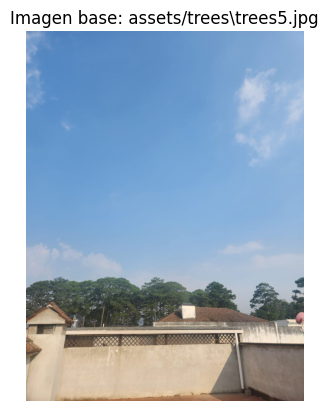

In [7]:
import cv2
import glob
import matplotlib.pyplot as plt

# Cargar imágenes
images = sorted(glob.glob("assets/trees/*.jpg"))
base_idx = len(images) // 2
image_base = cv2.imread(images[base_idx])
image_base_rgb = cv2.cvtColor(image_base, cv2.COLOR_BGR2RGB)

# Mostrar imagen base
plt.imshow(image_base_rgb)
plt.title(f"Imagen base: {images[base_idx]}")
plt.axis('off')
plt.show()


### Inciso 2. Detección de correspondencias y cálculo de homografías.

In [8]:
import numpy as np

def matching_pairs(img1, img2):
    orb = cv2.ORB_create(nfeatures=2000)
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    # Matching con fuerza bruta
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = matcher.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    # Convertir a puntos flotantes
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # Calcular homografía con RANSAC
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    return H, kp1, kp2, matches, mask


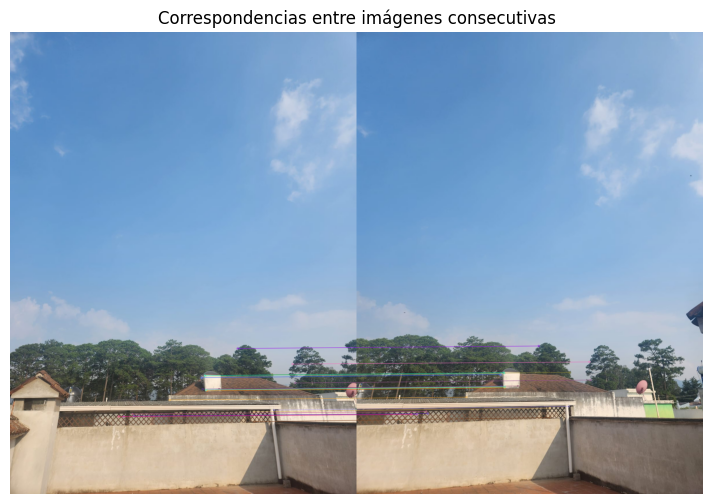

In [9]:
# Comparar imagen base con su vecina siguiente
img1 = cv2.imread(images[base_idx])
img2 = cv2.imread(images[base_idx + 1])

H, kp1, kp2, matches, mask = matching_pairs(img1, img2)

# Dibujar matches
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:20], None, flags=2)
img_matches_rgb = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(16, 6))
plt.imshow(img_matches_rgb)
plt.title("Correspondencias entre imágenes consecutivas")
plt.axis('off')
plt.show()


### Inciso 3. Warping

In [ ]:
# Código aquí.

### Inciso 4. Blending

In [ ]:
# Código aquí.